# Tutorial on geospatial trajectory data  management with MobilityDB

NOTE : We used the older version of the mobilitydb api for python, which is now deprecated but the new one is only supported on linux.

This tutorial is written by :
- **Romain Lambermont** (s190931)
- **Arthur Louis** (s191230)
- **Matteo Ruth** (s193932)
- **Adrien Saulas** (sXXXXXX)

## Introduction
In today's interconnected world, the availability of spatiotemporal data has witnessed an unprecedented surge. With the rise of location-based services, GPS trackers, and advancements in transportation systems, our ability to capture and analyze mobility patterns has expanded exponentially. This wealth of information holds immense potential in various domains, ranging from urban planning and logistics optimization to epidemiology and transportation network management.

To harness the full potential of spatiotemporal data, we require powerful tools and techniques that enable effective management and analysis. This is where MobilityDB steps in – an extension for PostgreSQL and PostGIS that empowers developers and data scientists to work with spatiotemporal data effortlessly. In this tutorial, we will dive into the world of MobilityDB, exploring its capabilities and demonstrating on a concrete example how we can use it.

## Why MobilityDB? 

MobilityDB is an extension of PostGIS, extending its capabilities to handle spatiotemporal data. With MobilityDB, the already powerful geospatial database becomes a comprehensive platform for managing and analyzing both spatial and temporal aspects simultaneously. It inculdes a lot of build-in functions to manipulate spatio-temporal data. 

We are going to first show you some of the basics of MobitilyDB and then show a more complex example by manipulating data from a public transportation database. Although this tutorial may not delve into intricate queries or intricate details, it will demonstrate how MobilityDB can be utilized to enhance route planning, optimize efficiency, and promote sustainability for engineers and transportation planners.

---

## Let's start!
First we need to install some dependencies if needed, set up docker and load the different libraries.

#### Requirements

- PostgreSQL (>= 14)
    - Windows :
        ```bash
        choco install postgresql15
        ```
    - Linux :
        ```bash
        sudo apt install postgresql-15
        ```
    - Mac :
        ```bash
        brew install libpq
        ```

#### Downloading and running the docker image for mobilitydb

Download the docker image
> docker pull mobilitydb/mobilitydb

Run the docker image
> docker run --name "mobilitydb" -d -p 25432:5432 -v mobilitydb_data*:/var/lib/postgresql mobilitydb/mobilitydb

*Replace mobilitydb_data with the path to the folder where you want to store the data

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import psycopg2
from mobilitydb.psycopg import register

from tqdm import tqdm

C:\Users\lambe\AppData\Local\Temp\ipykernel_19560\695246050.py:8: DeprecationWarning: The python-mobilitydb package is now deprecated and will no longer be mantained.Instead, the use of the new PyMEOS package is recommended. Check it out at https://pypi.org/project/pymeos/
  from mobilitydb.psycopg import register


#### Connection to the database running in a docker container

In [2]:
connection = None

try:
    connection = psycopg2.connect(host='localhost', database='mobilitydb', user='docker', password='docker', port='25432')
    connection.autocommit = True
    print("Connected to PostgreSQL")

    register(connection)
    print("MobilityDB extension enabled")

    cursor = connection.cursor()

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to MobilityDB", error)

Connected to PostgreSQL
MobilityDB extension enabled


---

### The Basics

First thing first, before doing too complex queries, we need to explain and show the basics of MobilityDB. 

#### Time Types and Range Types

How are we going to store data and/or a phenoma that evolves over both space $\textit{and}$ time?

##### timestamptz
The real building block of mobilityDB is $\texttt{timestamptz}$, which comes from PostgreSQL. It is a timestamp with a timezone. This could come handfull when we represent object that go through multiple timezones like boats or planes.

In [3]:
sql = "SELECT timestamptz '2023-05-26 13:00:00+02';"
cursor.execute(sql)
tsz = cursor.fetchone()[0]
print("\n timestamptz value from SQL:", tsz)


 timestamptz value from SQL: 2023-05-26 11:00:00+00:00


One notable observation is the transformation of the timestamp from our local time zone (+02 hours) to the Greenwich Mean Time reference (+00 hours). This adjustment ensures a standardized reference point across the data. When a timezone is not explicitly specified, MobilityDB assumes it to be in the default timezone.

##### period

$\texttt{period}$ is a new feature in mobilityDB that represent a interval where the bounds are $\texttt{timestamptz}$ which can be open or closed (respectively depicted as $\texttt{()}$ and $\texttt{[]}$).

As said earlier, MobilityDB implements a lot of build-in functions that permits us to easily manipulate data we show an example that gives us the duration of the period selected :

In [4]:
sql = "SELECT period '[2023-05-20 08:00:00, 2023-05-25 09:30:00)';"
cursor.execute(sql)
period = cursor.fetchone()[0]
print("\nPeriod value from SQL:", period)
print("Period type from SQL:", type(period), end='\n\n')

print("The list of functions and operators applicable to type period:")
print(dir(period))

print("\nFor example, the duration of the period:")
print(period.duration)


Period value from SQL: '[2023-05-20 08:00:00+00:00, 2023-05-25 09:30:00+00:00)'
Period type from SQL: <class 'mobilitydb.time.period.Period'>

The list of functions and operators applicable to type period:
['__class__', '__conform__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_cmp', '_cmp_boundSeqSet', '_lower', '_lower_inc', '_upper', '_upper_inc', '_valid', 'contains_timestamp', 'duration', 'getquoted', 'lower', 'lower_inc', 'overlap', 'read_from_cursor', 'shift', 'upper', 'upper_inc', 'write']

For example, the duration of the period:
5 days, 1:30:00


Another type that is implemented by mobilityDB are $\texttt{timestampset}$ and $\texttt{periodset}$ which are sets of those types :

In [5]:
sql = "SELECT timestampset '{2023-05-26 13:00:00+02, 2023-05-27 13:00:00+02}';"
cursor.execute(sql)
tsz = cursor.fetchone()[0]
print("\n timestamptset value from SQL:", tsz)

sql = "SELECT periodset '{[2023-05-26 08:00:00,2023-05-26 08:10:00], [2023-05-26 09:00:00,2023-05-26 09:30:00]}'"
cursor.execute(sql)
tsz = cursor.fetchone()[0]
print("\n periodset value from SQL:", tsz)



 timestamptset value from SQL: '{2023-05-26 11:00:00+00:00, 2023-05-27 11:00:00+00:00}'

 periodset value from SQL: '{[2023-05-26 08:00:00+00:00, 2023-05-26 08:10:00+00:00], [2023-05-26 09:00:00+00:00, 2023-05-26 09:30:00+00:00]}'


We will now show some easy operations you can apply on those types. Note that this is not an exhaustive list, we refer you to the documentation for a full list of possible operations

In [6]:
# We shift the timestampset by 1 day, each timestamp will be shifted by 1 day
sql = "SELECT shift(timestampset '{2001-01-01, 2001-01-03, 2001-01-05}', '1 day'::interval);"
cursor.execute(sql)
shift = cursor.fetchone()[0]

print("Shifted timestampset:", shift)

# We add two periods
sql = "SELECT period '[2011-01-01, 2011-01-05)' + period '[2011-01-03, 2011-01-07)';"
cursor.execute(sql)
period = cursor.fetchone()[0]

print("Addition of the two periods:", period)

Shifted timestampset: '{2001-01-02 00:00:00+00:00, 2001-01-04 00:00:00+00:00, 2001-01-06 00:00:00+00:00}'
Addition of the two periods: '{[2011-01-01 00:00:00+00:00, 2011-01-07 00:00:00+00:00)}'


##### temporal types

Now that we showed how does MobilityDB represent the time dimension, we will now see how to represent $something$ (an $\texttt{int}$, a $\texttt{float}$, a geographical position, ...) that evolves overtime.  

Between two points, mobilityDB will interpolate the value. It will interpolate it stepwise for temporal types based on discrete base types, that is $\texttt{tbool}$, $\texttt{tint}$, $\texttt{ttext}$, and it will interpolate it linearly for temporal types based on continuous base types, that is $\texttt{tfloat}$, $\texttt{tgeompoint}$, $\texttt{tgeogpoint}$.

To demonstrate that we are going to create two tables, one showing the number of students in different faculties and another showing the temperature in different classroom in the Montefiore Institute:

In [7]:
sql_drop_table = "DROP TABLE IF EXISTS Uliege, MontefioreRooms;"
cursor.execute(sql_drop_table)

In [8]:
sql_create_table = """
CREATE TABLE Uliege(
    FacultyName varchar(25),
    NbStudents tint
);
CREATE TABLE MontefioreRooms(
    Classroom varchar(25),
    Temperature tfloat
);
"""
cursor.execute(sql_create_table)

In [9]:
sql_insert_data = f"""
INSERT INTO Uliege VALUES
    ('FACSA', tint '[250@2019-09-15, 220@2020-09-15, 200@2021-09-15,  180@2022-09-15]'),
    ('FDSPC', tint '[800@2019-09-15, 500@2020-09-15, 300@2021-09-15, 200@2022-09-15]');
INSERT INTO MontefioreRooms VALUES
    ('R18', tfloat '[20.5@2023-06-15 12:00:00, 21.5@2023-06-15 14:00:00, 20.5@2023-06-15 16:00:00]'),
    ('I18', tfloat '[20.5@2023-06-15 12:00:00, 24.5@2023-06-15 14:00:00, 27.5@2023-06-15 16:00:00]');
"""
cursor.execute(sql_insert_data)


We are now going to do two simple queries to show how it could be used 

In [10]:
sql_query = """
SELECT FacultyName, atValue(NbStudents, 200)
FROM Uliege;
"""
cursor.execute(sql_query)
result = cursor.fetchall()
print("First query result:\n")

for row in result:
    FacultyName, stu_count = row
    print("Faculty name:", FacultyName)
    print("Time where the number of students was equal to 200:", stu_count)
    print("")

print(" ")
sql_query = """
SELECT Classroom, valueAtTimestamp(Temperature, '2023-06-15 15:00:00')
FROM MontefioreRooms;
"""
cursor.execute(sql_query)
result = cursor.fetchall()

print("Second query result:\n")

for row in result:
    className, temp = row
    print("Class name:", className)
    print("Temperature at 15:00 :", temp)
    print("")

First query result:

Faculty name: FACSA
Time where the number of students was equal to 200: '{[200@2021-09-15 00:00:00+00:00, 200@2022-09-15 00:00:00+00:00)}'

Faculty name: FDSPC
Time where the number of students was equal to 200: '{[200@2022-09-15 00:00:00+00:00]}'

 
Second query result:

Class name: R18
Temperature at 15:00 : 21.0

Class name: I18
Temperature at 15:00 : 26.0



We can now see how the interpolation works.

For the FACSA, we can see that the number of 200 students was constant for one year but we can see that the timestep 2022-09-15 00:00:00+00:00 is not included in the returned period, this expres that at that time, the number of students dropped to 180. 

For the temperature in the different rooms of Montefiore, the first thing we can notice is that we know which classroom is used for an exam, as the stress of the students is increasing the temperature. Secondly, we can see that it linearly interpolated the value, as the two values 21.0 and 26.0 were never entered in the database in the first hand. 

We can see that it will $\textbf{not}$ continue the extrapolation outside the range given: 

In [11]:
sql_query = """
SELECT Classroom, valueAtTimestamp(Temperature, '2023-06-15 19:00:00')
FROM MontefioreRooms;
"""
cursor.execute(sql_query)
result = cursor.fetchall()

for row in result:
    className, temp = row
    print("Class name:", className)
    print("Temperature at 19:00 :", temp)
    print("")

Class name: R18
Temperature at 19:00 : None

Class name: I18
Temperature at 19:00 : None



##### Bounding boxes

They could be seen as $\texttt{periods}$ on multiple dimensions, spatial and temporal.

To just give an example you can see here a spatio temporal box englobing the polytech faculty in space and over a time period of one year. The first values are the minimum values and to the right are the maximum values. 

Those boxes can be useful for different type of queries.

In [12]:
sql = "SELECT stbox 'STBOX T((50.5876, 5.5614, 2022-01-01), (50.5813, 5.5592, 2023-01-01))';"
cursor.execute(sql)
box = cursor.fetchone()[0]
print("\nstbox value from SQL:", box)
print("stbox type from SQL:", type(box), end='\n\n')

print("The list of functions and operators applicable to type stbox:")
print(dir(box))


stbox value from SQL: 'STBOX T((50.5813, 5.5592, 2022-01-01 00:00:00+00:00), (50.5876, 5.5614, 2023-01-01 00:00:00+00:00))'
stbox type from SQL: <class 'mobilitydb.boxes.stbox.STBox'>

The list of functions and operators applicable to type stbox:
['__class__', '__conform__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_geodetic', '_srid', '_tmax', '_tmin', '_xmax', '_xmin', '_ymax', '_ymin', '_zmax', '_zmin', 'geodetic', 'getquoted', 'parse_from_string', 'read_from_cursor', 'srid', 'tmax', 'tmin', 'write', 'xmax', 'xmin', 'ymax', 'ymin', 'zmax', 'zmin']


Before going to more complex queries, the last thing we can add are the aggregate functions.

They provide a generalization of the traditional aggregate functions we know in regular SQL. These functions calculate the value of the function at each moment within the combined temporal extents of the values being aggregated. 

Here are some of the temporal aggregate functions available, as for the simple operators, we refer you to the documentation for a more complete list:

##### TCOUNT

The tcount function generalizes the traditional count function. It allows you to determine the number of available objects at each point in time. It returns a tint.

For example, here we are doing a union of timestampset and then calculating the number of occurences of each timestamps:

In [13]:
sql = """
WITH times(ts) AS (
  SELECT timestampset '{2000-01-01, 2000-01-02, 2000-01-03}' UNION
  SELECT timestampset '{2000-01-01, 2000-01-02}' UNION
  SELECT timestampset '{2000-01-01}'
)
SELECT tcount(ts) FROM times;
"""
cursor.execute(sql)
count = cursor.fetchone()[0]
print("\nNumber of apparation of each timestamp:", count)


Number of apparation of each timestamp: '{3@2000-01-01 00:00:00+00:00, 2@2000-01-02 00:00:00+00:00, 1@2000-01-03 00:00:00+00:00}'


##### EXTEND
Returns a bounding period that encloses a set of time values.

For example here the extent function calculates the minimum and maximum timestamps that enclose the given time values, resulting in a single bounding period:

In [14]:
sql = """
WITH periods(ps) AS (
  SELECT periodset '{[2000-01-01, 2000-01-02], [2000-01-03, 2000-01-04]}' UNION
  SELECT periodset '{[2000-01-01, 2000-01-04], [2000-01-05, 2000-01-06]}' UNION
  SELECT periodset '{[2000-01-02, 2000-01-06]}'
)
SELECT ps FROM periods;
"""
cursor.execute(sql)
val = cursor.fetchall()
print("\nThe periodsets:")
for value in val:
    print(value[0])

sql = """
WITH periods(ps) AS (
  SELECT periodset '{[2000-01-01, 2000-01-02], [2000-01-03, 2000-01-04]}' UNION
  SELECT periodset '{[2000-01-01, 2000-01-04], [2000-01-05, 2000-01-06]}' UNION
  SELECT periodset '{[2000-01-02, 2000-01-06]}'
)
SELECT extent(ps) FROM periods;
"""
cursor.execute(sql)
ex = cursor.fetchone()[0]
print("\nThe extended period:", ex)


The periodsets:
'{[2000-01-01 00:00:00+00:00, 2000-01-04 00:00:00+00:00], [2000-01-05 00:00:00+00:00, 2000-01-06 00:00:00+00:00]}'
'{[2000-01-01 00:00:00+00:00, 2000-01-02 00:00:00+00:00], [2000-01-03 00:00:00+00:00, 2000-01-04 00:00:00+00:00]}'
'{[2000-01-02 00:00:00+00:00, 2000-01-06 00:00:00+00:00]}'

The extended period: '[2000-01-01 00:00:00+00:00, 2000-01-06 00:00:00+00:00]'


To vizualise what is happening you can look at the following plot to see what this query does exactly :

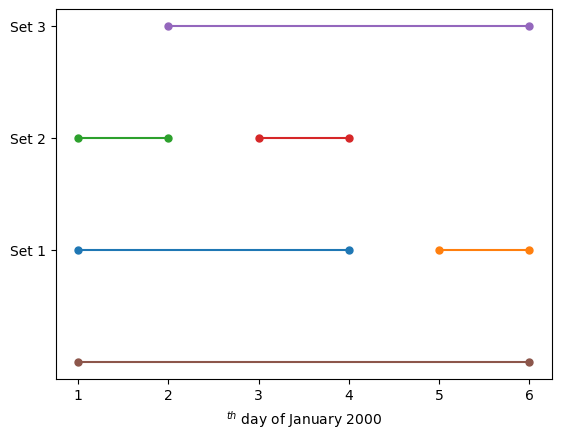

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for i, v in enumerate(val):
    for p in v[0].periods:
        ax.plot([p.lower.day, p.upper.day], [i+1, i+1], marker='o', markersize=5)

yticks = list(range(len(val) + 1,0,-1))
ax.set_yticks(yticks)
ax.set_yticklabels(['Result']+ [f"Set {len(val) - i}" for i in range(len(val))])

ax.plot([ex.lower.day, ex.upper.day], [0, 0], marker='o', markersize=5)

ax.set_xlabel(r"$^{th}$ day of January 2000")

plt.show()

#### TUNION

What if we want to combine an arbitrary number of values. Function tunion can be used for this purpose:

In [16]:
sql = """
WITH periods(ps) AS (
  SELECT periodset '{[2000-01-01, 2000-01-02], [2000-01-03, 2000-01-04]}' UNION
  SELECT periodset '{[2000-01-02, 2000-01-03], [2000-01-05, 2000-01-06]}' UNION
  SELECT periodset '{[2000-01-07, 2000-01-08]}'
)
SELECT ps FROM periods;
"""
cursor.execute(sql)
val = cursor.fetchall()
print("\nThe periodsets:")
for value in val:
    print(value[0])

sql = """
WITH periods(ps) AS (
  SELECT periodset '{[2000-01-01, 2000-01-02], [2000-01-03, 2000-01-04]}' UNION
  SELECT periodset '{[2000-01-02, 2000-01-03], [2000-01-05, 2000-01-06]}' UNION
  SELECT periodset '{[2000-01-07, 2000-01-08]}'
)
SELECT tunion(ps) FROM periods;
"""
cursor.execute(sql)
un = cursor.fetchone()[0]
print("\nThe union of the periodsets:")
for p in un.periods:
    print(p)


The periodsets:
'{[2000-01-01 00:00:00+00:00, 2000-01-02 00:00:00+00:00], [2000-01-03 00:00:00+00:00, 2000-01-04 00:00:00+00:00]}'
'{[2000-01-02 00:00:00+00:00, 2000-01-03 00:00:00+00:00], [2000-01-05 00:00:00+00:00, 2000-01-06 00:00:00+00:00]}'
'{[2000-01-07 00:00:00+00:00, 2000-01-08 00:00:00+00:00]}'

The union of the periodsets:
'[2000-01-01 00:00:00+00:00, 2000-01-04 00:00:00+00:00]'
'[2000-01-05 00:00:00+00:00, 2000-01-06 00:00:00+00:00]'
'[2000-01-07 00:00:00+00:00, 2000-01-08 00:00:00+00:00]'


You can once again vizualise what is happening with the following plot : 

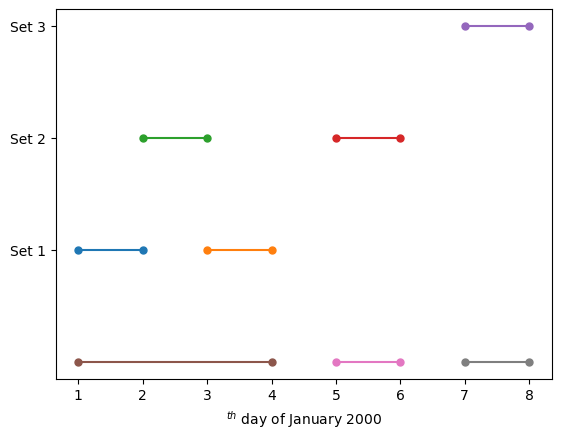

In [17]:

fig, ax = plt.subplots()
for i, v in enumerate(val):
    for p in v[0].periods:
        ax.plot([p.lower.day, p.upper.day], [i+1, i+1], marker='o', markersize=5)

yticks = list(range(len(val) + 1,0,-1))
ax.set_yticks(yticks)
ax.set_yticklabels(['Result']+ [f"Set {len(val) - i}" for i in range(len(val))])

for int in un.periods:
    ax.plot([int.lower.day, int.upper.day], [0, 0], marker='o', markersize=5)

ax.set_xlabel(r"$^{th}$ day of January 2000")

plt.show()

## Concrete example : TEC (bus lines in Province de Liège)

### Getting the TEC data from the official website (keep it as zip)

In [18]:
compute = True

The zip file containing all the data can be found here: https://opendata.tec-wl.be/Current%20GTFS/TEC-GTFS.zip

unzip it in the data subfolder

### Load the data into the database

### Isolate the Data for Province de Liège

In [19]:
# Calendar : we want to keep only the services of Province de Liege and transform the calendar to have one row per week

if compute:
    # Remove calendar with service_id not starting by 'L'
    calendar = pd.read_csv('data/calendar.txt')
    calendar = calendar[calendar['service_id'].str.startswith('L')]

    new_calendar = pd.DataFrame(columns=['service_id', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'])

    for index, row in calendar.iterrows():
        start_date = row['start_date']
        end_date = row['end_date']
        service_id = row['service_id']

        start_date = pd.to_datetime(start_date, format='%Y%m%d')
        end_date = pd.to_datetime(end_date, format='%Y%m%d')
        
        start_monday = start_date - pd.to_timedelta(start_date.dayofweek, unit='d')
        end_sunday = end_date + pd.to_timedelta(6 - end_date.dayofweek, unit='d')

        nb_weeks = (end_sunday - start_monday).days // 7 + 1

        # create a new row for each week
        for i in range(nb_weeks):
            new_row = {
                'service_id': f'{service_id}_{i}',
                'monday': None,
                'tuesday': None,
                'wednesday': None,
                'thursday': None,
                'friday': None,
                'saturday': None,
                'sunday': None
            }

            # looking into the original row, set the days that are active
            for day in range(7):
                if row[calendar.columns[day+1]] == 1:
                    new_row[calendar.columns[day+1]] = start_monday + pd.to_timedelta(i*7 + day, unit='d')

            new_calendar.loc[len(new_calendar)] = new_row

    new_calendar.to_csv('data/calendar.txt', index=False)

In [20]:
# Agency : we want to keep only the agency of Province de Liege

if compute:
    agency = pd.read_csv('data/agency.txt')
    agency = agency[agency['agency_id'] == 'L']
    agency.to_csv('data/agency.txt', index=False)

In [21]:
# Routes : we want to keep only the routes of Province de Liege
if compute:
    routes = pd.read_csv('data/routes.txt')
    routes = routes[routes['agency_id'] == 'L']
    routes.to_csv('data/routes.txt', index=False)

In [22]:
# Trips : we want to keep only the trips of Province de Liege

if compute:
    # Remove trips with route_id not starting by 'L'
    trips = pd.read_csv('data/trips.txt')
    trips = trips[trips['route_id'].str.startswith('L')]

    # Remove column shape_id and block_id from trips
    trips = trips.drop(columns=['block_id','shape_id'])
    trips.to_csv('data/trips.txt', index=False)

In [23]:
# Stops : we want to keep only the stops of Province de Liege

if compute:
    stops = pd.read_csv('data/stops.txt')
    stops = stops[stops['stop_id'].str.startswith('L')]
    stops.to_csv('data/stops.txt', index=False)

In [24]:
if compute:
    # Remove stop_times with stop_id not starting by 'L'
    stop_times = pd.read_csv('C:\\Users\\lambe\\OneDrive\\Documents\\Inge_master_1\\AD\\AD-MobilityDB_Tutorial\\data\\stop_times.txt')
    stop_times = stop_times[stop_times['stop_id'].str.startswith('L')]
    stop_times = stop_times[stop_times['trip_id'].str.contains('-L_')]

    # Remove rows when the arrival time and departure time is greater than '23:59:59'
    stop_times = stop_times[(stop_times['arrival_time'].str[:2] < '24')]
    stop_times = stop_times[(stop_times['departure_time'].str[:2] < '24')]

    # if two consecutive rows have the same arrival_time drop the second one
    stop_times = stop_times.drop_duplicates(subset=['trip_id', 'arrival_time'], keep='first')

    # Transform departure_time and arrival_time to datetime our format is HH:MM:SS
    stop_times['departure_time'] = pd.to_datetime(stop_times['departure_time'], format='%H:%M:%S')
    stop_times['arrival_time'] = pd.to_datetime(stop_times['arrival_time'], format='%H:%M:%S')

    stop_times.to_csv('data/stop_times.txt', index=False)

### Load the data into the database

In [25]:
# Loading our data in PostgreSQL

with open('sql/load.sql', 'r') as f:
    cursor.execute(f.read())

print("Data loaded")

Data loaded


In [26]:
# Creating the calendar_trips to have a "full" calendar with dates

with open('sql/manipulation.sql', 'r') as f:
    cursor.execute(f.read())

print("Data manipulated")

Data manipulated


In [27]:
# Checking that everything went well

query = "SELECT * FROM calendar LIMIT 10"
cursor.execute(query)

colnames = [desc[0] for desc in cursor.description]
print(colnames)

for row in cursor.fetchall():
    print(row)

query = "SELECT * FROM calendar_trips WHERE service_id = 'L_PA_2023-23_LG_N3-Sem-N-3-26-1001100_0' LIMIT 10"
cursor.execute(query)

colnames = [desc[0] for desc in cursor.description]
print("\n" + str(colnames))

for row in cursor.fetchall():
    print(row)

['service_id', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
('L_PA_2023-23_LG_DI-Dimanche-05_0', None, None, None, None, None, None, datetime.date(2023, 5, 14))
('L_PA_2023-23_LG_DI-Dimanche-05_1', None, None, None, None, None, None, datetime.date(2023, 5, 21))
('L_PA_2023-23_LG_DI-Dimanche-05_2', None, None, None, None, None, None, datetime.date(2023, 5, 28))
('L_PA_2023-23_LG_DI-Dimanche-05_3', None, None, None, None, None, None, datetime.date(2023, 6, 4))
('L_PA_2023-23_LG_DI-Dimanche-06_0', None, None, None, None, None, None, datetime.date(2023, 6, 4))
('L_PA_2023-23_LG_DI-Dimanche-06_1', None, None, None, None, None, None, datetime.date(2023, 6, 11))
('L_PA_2023-23_LG_DI-Dimanche-06_2', None, None, None, None, None, None, datetime.date(2023, 6, 18))
('L_PA_2023-23_LG_DI-Dimanche-06_3', None, None, None, None, None, None, datetime.date(2023, 6, 25))
('L_PA_2023-23_LG_DI-Dimanche-06_4', None, None, None, None, None, None, datetime.date(2023, 7, 2))
(

### Transform the data into a MobilityDB trajectory

In [28]:
# Transforming our data into MobilityDB

with open('sql/mobility.sql', 'r') as f:
    cursor.execute(f.read())

print("Mobility functions loaded")

Mobility functions loaded


In [29]:
# Checking that everything went well
# Be aware that all the trajectories take place on the 1st January 1900
# This is a trick used to avoid the computation of all the trajectories, around 24 hours of computation vs 1-2 minutes
# We will query the database in the correct way using the calendar, service_id and trip_id to obtain the trajectories on the correct date

query = "SELECT * FROM stop_times_traj LIMIT 10;"
cursor.execute(query)

for row in cursor.fetchall():
    print(row)

('36073863-L_PA_2023-23_LG_DI-Dimanche-05', TGeomPointSeq([TGeomPointInst(<Point POINT(5.243113994598389 50.52419662475586)>, datetime.datetime(1900, 1, 1, 17, 6, tzinfo=tzutc())), TGeomPointInst(<Point POINT(5.237812042236328 50.52219009399414)>, datetime.datetime(1900, 1, 1, 17, 9, tzinfo=tzutc())), TGeomPointInst(<Point POINT(5.231204032897949 50.524837493896484)>, datetime.datetime(1900, 1, 1, 17, 10, tzinfo=tzutc())), TGeomPointInst(<Point POINT(5.221620082855225 50.52911376953125)>, datetime.datetime(1900, 1, 1, 17, 12, tzinfo=tzutc())), TGeomPointInst(<Point POINT(5.219347953796387 50.53200912475586)>, datetime.datetime(1900, 1, 1, 17, 13, tzinfo=tzutc())), TGeomPointInst(<Point POINT(5.218832969665527 50.534996032714844)>, datetime.datetime(1900, 1, 1, 17, 14, tzinfo=tzutc())), TGeomPointInst(<Point POINT(5.209020137786865 50.53449249267578)>, datetime.datetime(1900, 1, 1, 17, 15, tzinfo=tzutc())), TGeomPointInst(<Point POINT(5.203918933868408 50.53114700317383)>, datetime.date

## Let's now use the MobilityDB functions

### Imagine you want to know what bus to take to go to the University of Liège at 8:00 from the train station (Liège-Guillemins) 

In [30]:
# Creation of our day of interest
hour_of_interest = "8:00:00"
day_of_interest = pd.to_datetime("2023-06-02", format='%Y-%m-%d')
date_of_interest = day_of_interest.date()
dayname = day_of_interest.day_name()

# Isolate the service_id of the day of interest
query = f"SELECT DISTINCT service_id FROM calendar_trips WHERE {dayname} = '{date_of_interest}'"
cursor.execute(query)

services = cursor.fetchall()
services = [service[0] for service in services]

# We will then isolate the zones of interest
box_tolerance = 0.001
 
lon_polytech = 5.560434
lat_polytech = 50.584305

lat_min_polytech = lat_polytech - box_tolerance
lat_max_polytech = lat_polytech + box_tolerance
lon_min_polytech = lon_polytech - box_tolerance
lon_max_polytech = lon_polytech + box_tolerance

lon_guillemins = 5.567853
lat_guillemins = 50.62537

lat_min_guillemins = lat_guillemins - box_tolerance
lat_max_guillemins = lat_guillemins + box_tolerance
lon_min_guillemins = lon_guillemins - box_tolerance
lon_max_guillemins = lon_guillemins + box_tolerance

query = f'SELECT trip_id FROM stop_times_traj WHERE intersects(traj, ST_MakeEnvelope({lon_min_polytech}, {lat_min_polytech}, {lon_max_polytech}, {lat_max_polytech}, 4326)) AND intersects(traj, ST_MakeEnvelope({lon_min_guillemins}, {lat_min_guillemins}, {lon_max_guillemins}, {lat_max_guillemins}, 4326))'
cursor.execute(query)

trips = cursor.fetchall()
trips = [trip[0] for trip in trips]

if len(services) == 1:
    formated_services = f"('{services[0]}')"
else:
    formated_services = tuple(services)

# Isolate the trips that have the correct service_id
query = f"SELECT trip_id FROM calendar_trips WHERE service_id IN {formated_services}"
cursor.execute(query)

trips_correct_services = cursor.fetchall()
trips_correct_services = [trip[0][:-2] for trip in trips_correct_services]

print(f"Number of trips during the day of interest : {len(trips_correct_services)}")

trips = list(set(trips_correct_services).intersection(trips))

print(f"Number of trips connecting the two zones on the day of interest : {len(trips)}")

# Using those trips we can now isolate the stop_times of interest
query = f"SELECT * FROM stop_times WHERE trip_id IN {tuple(trips)} AND arrival_time <= '1900-01-01 {hour_of_interest}' AND stop_id LIKE 'Lstpoly%'"
cursor.execute(query)

final_trips = cursor.fetchall()
final_trips = [trip[0] for trip in final_trips]

# The stop_sequence was hardcoded to make sure the bus goes in the right direction
print("\nTimes of departure of the bus from Guillemins to get to Polytech at 8:00 :")
query = f"SELECT DISTINCT stop_name, departure_time, route_short_name FROM stop_times INNER JOIN stops ON stop_times.stop_id = stops.stop_id INNER JOIN trips ON stop_times.trip_id = trips.trip_id INNER JOIN routes ON trips.route_id = routes.route_id WHERE stop_times.trip_id IN {tuple(final_trips)} AND stop_times.stop_id LIKE 'LlgguilB%' AND departure_time <= '1900-01-01 {hour_of_interest}' AND stop_sequence < 10 ORDER BY departure_time ASC"
cursor.execute(query)

# Store in a pandas dataframe
colnames = [desc[0] for desc in cursor.description]
df = pd.DataFrame(columns=colnames)
for row in cursor.fetchall():
    index = len(df)
    df.loc[index] = (row[0], row[1].strftime("%H:%M:%S"), row[2])

df.head(20)

Number of trips during the day of interest : 84748
Number of trips connecting the two zones on the day of interest : 458

Times of departure of the bus from Guillemins to get to Polytech at 8:00 :


,stop_name,departure_time,route_short_name
0,LIEGE Gare des Guillemins - Quai B,05:28:00,48
1,LIEGE Gare des Guillemins - Quai B,05:56:00,48
2,LIEGE Gare des Guillemins - Quai B,06:27:00,48
3,LIEGE Gare des Guillemins - Quai B,06:45:00,48
4,LIEGE Gare des Guillemins - Quai B,07:00:00,58
5,LIEGE Gare des Guillemins - Quai B,07:03:00,48
6,LIEGE Gare des Guillemins - Quai B,07:14:00,48
7,LIEGE Gare des Guillemins - Quai B,07:15:00,58
8,LIEGE Gare des Guillemins - Quai B,07:24:00,48
9,LIEGE Gare des Guillemins - Quai B,07:30:00,58


### Create a box of interest around the campus of ULiège

In [31]:
# Identification of the routes that go through the area of interest

# Campus of ULiège in Sart-Tilman
LAT_MIN = 50.5820
LAT_MAX = 50.6022
LON_MIN = 5.5483
LON_MAX = 5.5869

query = f"SELECT DISTINCT route_short_name FROM stop_times_traj INNER JOIN trips ON stop_times_traj.trip_id = trips.trip_id INNER JOIN routes ON trips.route_id = routes.route_id WHERE intersects(traj, ST_MakeEnvelope({LON_MIN}, {LAT_MIN}, {LON_MAX}, {LAT_MAX}, 4326));"
cursor.execute(query)

print("Routes that go through the area of interest :")
for row in cursor.fetchall():
    print(row[0])

Routes that go through the area of interest :
158
248
25
28
41
48
58
E20


### Heatmap of the bus lines inside the Province of Liège

In [32]:
# Getting the limiting coordinates of the area of interest

# lowest latitude
query = "SELECT MIN(stop_lat) FROM stop_times_coord;"
cursor.execute(query)

low_lat = None
for row in cursor.fetchall():
    low_lat = row[0]

# highest latitude
query = "SELECT MAX(stop_lat) FROM stop_times_coord;"
cursor.execute(query)

high_lat = None
for row in cursor.fetchall():
    high_lat = row[0]

# lowest longitude
query = "SELECT MIN(stop_lon) FROM stop_times_coord;"
cursor.execute(query)

low_lon = None
for row in cursor.fetchall():
    low_lon = row[0]

# highest longitude
query = "SELECT MAX(stop_lon) FROM stop_times_coord;"
cursor.execute(query)

high_lon = None
for row in cursor.fetchall():
    high_lon = row[0]

print(low_lat, high_lat, low_lon, high_lon)

50.1403 50.851456 5.045672 6.384263


In [33]:
# Creation of different areas of interest

# Sart-Tilman
query = f"SELECT traj FROM stop_times_traj WHERE intersects(traj, ST_MakeEnvelope({LON_MIN}, {LAT_MIN}, {LON_MAX}, {LAT_MAX}, 4326));"
cursor.execute(query)

trajs_srt = []
for row in tqdm(cursor.fetchall()):
    trajs_srt.append(row[0])

# Saint-Lambert
LAT_MIN_SL = 50.6439
LAT_MAX_SL = 50.6462
LON_MIN_SL = 5.5720
LON_MAX_SL = 5.5760
query = f"SELECT traj FROM stop_times_traj WHERE intersects(traj, ST_MakeEnvelope({LON_MIN_SL}, {LAT_MIN_SL}, {LON_MAX_SL}, {LAT_MAX_SL}, 4326));"
cursor.execute(query)

trajs_stlamber = []
for row in tqdm(cursor.fetchall()):
    trajs_stlamber.append(row[0])

# Eupen
LAT_MIN_EU = 50.6133
LAT_MAX_EU = 50.6525
LON_MIN_EU = 6.0006
LON_MAX_EU = 6.0722
query = f"SELECT traj FROM stop_times_traj WHERE intersects(traj, ST_MakeEnvelope({LON_MIN_EU}, {LAT_MIN_EU}, {LON_MAX_EU}, {LAT_MAX_EU}, 4326));"
cursor.execute(query)

trajs_marche = []
for row in tqdm(cursor.fetchall()):
    trajs_marche.append(row[0])

100%|██████████| 4459/4459 [00:00<00:00, 2234189.65it/s]


100%|██████████| 4459/4459 [00:05<00:00, 770.84it/s] 


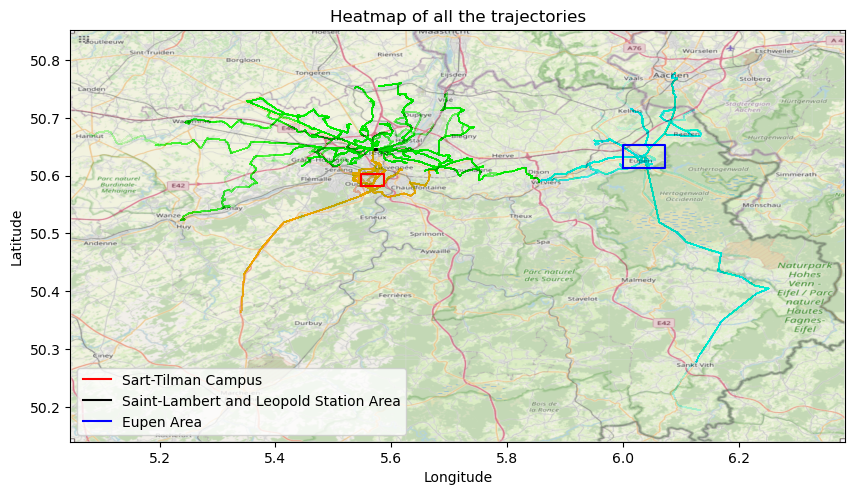

In [34]:
# Creating the heatmap for the different areas of interest

plt.figure(figsize=(10, 14))

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.xlim(low_lon, high_lon)
plt.ylim(low_lat, high_lat)

plt.imshow(plt.imread('figs/map.png'), extent=[low_lon, high_lon, low_lat, high_lat])

for i in tqdm(range(len(trajs_srt))):
    x = []
    y = []
    for j in range(trajs_srt[i].numInstants):
        x.append(trajs_srt[i].getValues[j].x)
        y.append(trajs_srt[i].getValues[j].y)
    plt.plot(x, y, color='orange', alpha=0.005)

for i in tqdm(range(len(trajs_stlamber))):
    x = []
    y = []
    for j in range(trajs_stlamber[i].numInstants):
        x.append(trajs_stlamber[i].getValues[j].x)
        y.append(trajs_stlamber[i].getValues[j].y)
    plt.plot(x, y, color='lime', alpha=0.005)

for i in tqdm(range(len(trajs_marche))):
    x = []
    y = []
    for j in range(trajs_marche[i].numInstants):
        x.append(trajs_marche[i].getValues[j].x)
        y.append(trajs_marche[i].getValues[j].y)
    plt.plot(x, y, color='aqua', alpha=0.005)


plt.plot([LON_MIN, LON_MIN, LON_MAX, LON_MAX, LON_MIN], [LAT_MIN, LAT_MAX, LAT_MAX, LAT_MIN, LAT_MIN], color='red', label='Sart-Tilman Campus')
plt.plot([LON_MIN_SL, LON_MIN_SL, LON_MAX_SL, LON_MAX_SL, LON_MIN_SL], [LAT_MIN_SL, LAT_MAX_SL, LAT_MAX_SL, LAT_MIN_SL, LAT_MIN_SL], color='black', label='Saint-Lambert and Leopold Station Area')
plt.plot([LON_MIN_EU, LON_MIN_EU, LON_MAX_EU, LON_MAX_EU, LON_MIN_EU], [LAT_MIN_EU, LAT_MAX_EU, LAT_MAX_EU, LAT_MIN_EU, LAT_MIN_EU], color='blue', label='Eupen Area')

plt.title('Heatmap of all the trajectories')

plt.legend()
plt.savefig('figs/heatmap.png')
plt.show()

### Plot the number of bus lines in circulation over time

In [35]:
# By isolating the the service_id of the day of interest, we can isolate the trip_id of the day of interest

day_of_interest = pd.to_datetime("2023-06-02", format='%Y-%m-%d')

date_of_interest = day_of_interest.date()
dayname = day_of_interest.day_name()

# Isolate the service_id of the day of interest
query = f"SELECT DISTINCT service_id FROM calendar_trips WHERE {dayname} = '{date_of_interest}'"
cursor.execute(query)

services = cursor.fetchall()
services = [service[0] for service in services]

if len(services) == 1:
    formated_services = f"('{services[0]}')"
else:
    formated_services = tuple(services)

# Isolate the trip_id of the day of interest
query = f"SELECT DISTINCT trip_id FROM calendar_trips WHERE service_id IN {formated_services}"
cursor.execute(query)

trips = cursor.fetchall()
trips = [trip[0] for trip in trips]
trips = [trip[:-2] for trip in trips]

if len(trips) == 1:
    formated_trips = f"('{trips[0]}')"
else:
    formated_trips = tuple(trips[:])

# Isolate the correct trajectories
query = f"SELECT * FROM stop_times_traj WHERE trip_id IN {formated_trips}"
cursor.execute(query)

trajs = []
for row in cursor.fetchall():
    trajs.append(row[1])


1900-01-01 06:20:00+00:00
Median duration of a trip: 33.068891645055814 minutes


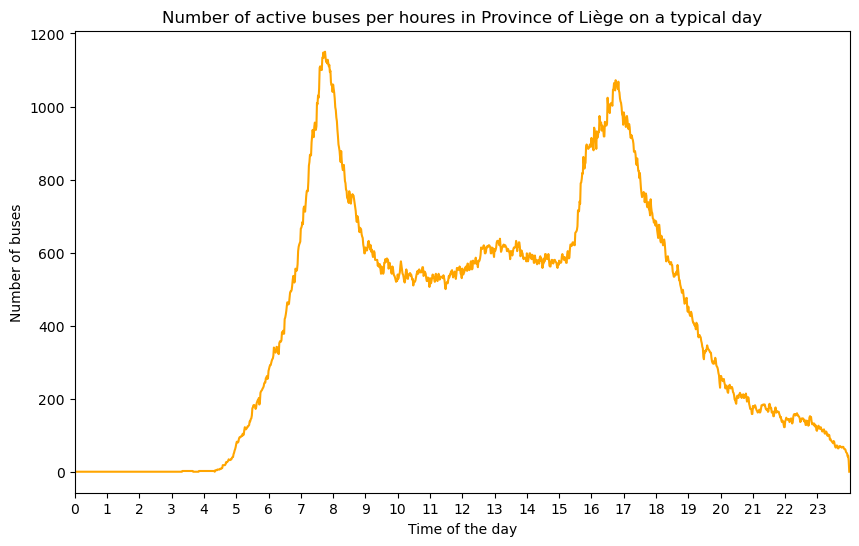

In [36]:
# Iterating over the trajectories to find the median duration of a trip
# and to create a plot of the evolution of the number of active buses over the day

minutes = 24 * 60
nb_busses = np.zeros(minutes)

print(trajs[0].startTimestamp)


median_duration = 0

for traj in trajs:
    median_duration += traj.duration.total_seconds()
    start = traj.startTimestamp
    end = traj.endTimestamp
    start = start.hour * 60 + start.minute
    end = end.hour * 60 + end.minute
    nb_busses[start:end] += 1

median_duration /= len(trajs)*60

print(f"Median duration of a trip: {median_duration} minutes")

plt.figure(figsize=(10, 6))
plt.xlabel('Time of the day')
plt.ylabel('Number of buses')
plt.xlim(0, minutes)
plt.xticks(np.arange(0, minutes, 60), np.arange(0, 24, 1))
plt.title('Number of active buses per houres in Province of Liège on a typical day')
plt.plot(nb_busses, color='orange', label='Number of buses')
plt.savefig('figs/number_of_buses.png')
plt.show()